#### System Setup

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import os

In [2]:
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True, warn_only=True)

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch.manual_seed(40)
torch.cuda.manual_seed_all(40)

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'


In [4]:
device

'cpu'

In [5]:
def read_image_tensor(image_folder,transform):
    all_images = []
    for subdir in os.listdir(image_folder)[:10]:
        for images in os.listdir(os.path.join(image_folder,subdir)):
            img = torchvision.io.read_image(os.path.join(image_folder,subdir,images)).float()
            all_images.append(transform(img))
        print(f"Done with {subdir}")
    return torch.stack(all_images).to(device)

In [6]:
import os, cv2, random
def generate(img):
    # SIRF algorithm to detect key points in the image
    # print(img.shape)
    # plt.imshow(img)
    # features = cv2.SIFT_create()
    # keypoints = features.detect(img, None)
    # # Choose top 50 and bottom 50 keypoints
    # keypoints1 = sorted(keypoints, key=lambda x: -x.response)[:min(50, len(keypoints))]
    # keypoints2 = sorted(keypoints, key=lambda x: x.response)[:min(50, len(keypoints))]
    # # Randomly choose 3 keypoints from each set
    # keypoints1 = random.sample(keypoints1, 3)
    # keypoints2 = random.sample(keypoints2, 3)
    
    # # between every two keypoints draw a line
    # for i in range(len(keypoints1)):
    #     for j in range(len(keypoints2)):
    #         x1, y1 = keypoints1[i].pt
    #         x2, y2 = keypoints2[j].pt
    #         x1 = int(x1)
    #         y1 = int(y1)
    #         x2 = int(x2)
    #         y2 = int(y2)
    #         cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), random.randint(1,8))
    

    #### 
    # Add random white spots to the image
    # show the image
    min_num_spots, max_num_spots = 5, 8
    min_spot_size, max_spot_size = 10, 25
    for _ in range(random.randint(min_num_spots, max_num_spots)):
        spot_size = random.randint(min_spot_size, max_spot_size)
        spot_x = random.randint(0, 256 - spot_size)
        spot_y = random.randint(0, 256 - spot_size)
        color = (255, 255, 255)  # White color in RGB format
        if random.choice([0,1]) == 1:
            # rectangle
            img[spot_y:spot_y + spot_size, spot_x:spot_x + spot_size] = color
        else:
            # circle
            cv2.circle(img, (spot_x, spot_y), spot_size, color, thickness=-1)

    return img

In [7]:

def make_input(labels):
    # apply generate input_image function on each image in labels and return the tensor of it
    images=[]
    for label in labels:
        img=np.array(label.permute(1,2,0).int())
        img = cv2.resize(img, (128, 128))
        gen_img= generate(img)
        gen_img = np.array(torch.tensor(gen_img).permute(2,0,1).float())
        images.append(gen_img)
    
    return torch.tensor(images).to(device)

In [8]:
img_size = (128,128)
base_transform = transforms.Compose(
    [transforms.Resize(img_size)
    ]
)

dataset = read_image_tensor("../animals/animals", base_transform)
dataset.shape

/opt/homebrew/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Done with hippopotamus
Done with sparrow
Done with gorilla
Done with cat
Done with rhinoceros
Done with wombat
Done with seahorse
Done with butterfly
Done with donkey
Done with raccoon


torch.Size([600, 3, 128, 128])

480
120


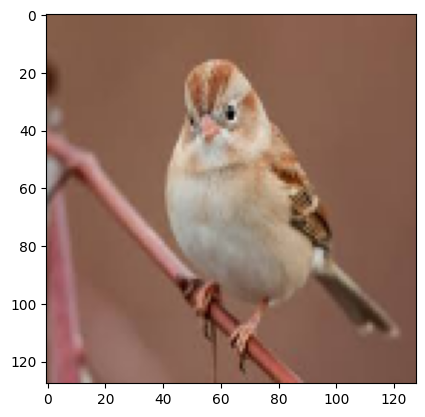

In [9]:
import matplotlib.pyplot as plt
import  numpy as np
train_ratio = 0.8
train_set, test_set = torch.utils.data.random_split(dataset, [int(train_ratio*len(dataset)), len(dataset)-int(train_ratio*len(dataset))])

print(len(train_set))
print(len(test_set))

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=32,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=32,
                                          shuffle=False)

plt.imshow(dataset[100].permute(1,2,0).int())

In [10]:
from models import *

model = AutoEncoder(in_channels=3, out_channels=3)
model.to(device)

AutoEncoder(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [11]:
def train_model(model, loss_fn, optimizer, num_epochs, train_loader, test_loader):
  for epoch in range(num_epochs):
      for data in train_loader:
          img = data
          img = img.to(device)
          optimizer.zero_grad() 
          transformed_img = make_input(img).float()
          output= model(transformed_img)
          loss = loss_fn(output, img)
          loss.backward()
          optimizer.step()
    #   if (epoch+1) % 5== 0:
      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [12]:
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
epochs = 20

train_model(model, loss, optimizer, epochs, train_loader, test_loader)

/var/folders/rz/zxxz9kjn5k7bt_df2j7m9hbh0000gn/T/ipykernel_45307/481976025.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.tensor(images).to(device)


Epoch [1/20], Loss: 16702.1621
Epoch [2/20], Loss: 18909.5566
Epoch [3/20], Loss: 18834.9766
Epoch [4/20], Loss: 21530.7832
Epoch [5/20], Loss: 22019.7969
Epoch [6/20], Loss: 19408.0820
Epoch [7/20], Loss: 19446.6855
Epoch [8/20], Loss: 17246.6797
Epoch [9/20], Loss: 20553.2324
Epoch [10/20], Loss: 16675.6836
Epoch [11/20], Loss: 18829.9590
Epoch [12/20], Loss: 17691.3379
Epoch [13/20], Loss: 19038.1348
Epoch [14/20], Loss: 22138.4375
Epoch [15/20], Loss: 21852.0684
Epoch [16/20], Loss: 18787.7910
Epoch [17/20], Loss: 18763.6348
Epoch [18/20], Loss: 18726.1504
Epoch [19/20], Loss: 18389.1543
Epoch [20/20], Loss: 19580.3906


In [13]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

# Load the model checkpoint
model.load_state_dict(torch.load('model.ckpt'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average Test Reconstruction Loss: 18440.66357421875


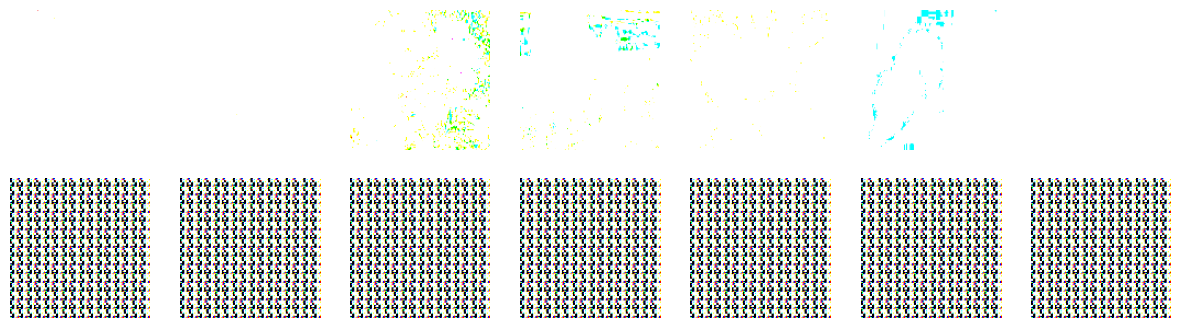

In [34]:
with torch.no_grad():
    losses = []
    for data in test_loader:
        data = data.to(device)
        recon = model(data)
        losses.append(nn.MSELoss()(recon, data).item())
    print(f"Average Test Reconstruction Loss: {sum(losses)/len(losses)}")

# plt.imshow(data[1].permute(1,2,0).int())
# plt.imshow(recon[2].permute(1,2,0).int())
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()
